![](https://cdn.corporate.walmart.com/dims4/WMT/c2bbbe9/2147483647/strip/true/crop/2389x930+0+0/resize/1446x563!/quality/90/?url=https%3A%2F%2Fcdn.corporate.walmart.com%2Fd6%2Fe7%2F48e91bac4a8ca8f22985b3682370%2Fwalmart-logos-lockupwtag-horiz-blu-rgb.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


![](https://dox4euoyzny9u.cloudfront.net/images/blog/uploads/dataprocessinggdpr.jpg)

**Organização do documento**

1. Carregando os dados de entrada e carregando bibliotecas<br>
   1.1 Manipulação com os dados Iniciais<br>
2. Elaboração de 4 questões que ajudem a compreender os dados<br>
   2.1 Questão 1: Os feriados impactam nas vendas?<br>
   2.2 Questão 2: As vendas semanais são consistentes ao longo dos anos?<br>
   2.3 Questão 3: Existe relevância na correlação das variáveis?<br>
   2.4 Questão 4: <br>
3. Listar 1 limpeza que precisa ser feita nos dados e a executar <br>
4. Planejamento de aplicação de Machine Learning para resolver o problema <br>
   4.1 Escolher um algoritmo de Machine Learning <br>
   4.2 Comentar sobre a escolha do algoritmo <br>
5. Autocrítica e próximos passos <br>
   5.1 Enumerar eventuais problemas e limitações da estratégia <br>
   5.2 Comentar sobre o que você teria feito se tivesse mais tempo para tratar o problema <br>
   
# Carregando os dados de entrada e bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


input_path  = '/kaggle/input/walmart-recruiting-store-sales-forecasting/'
train_data  = pd.read_csv(os.path.join(input_path, 'train.csv.zip'))
stores_data = pd.read_csv(os.path.join(input_path, 'stores.csv'))
features    = pd.read_csv(os.path.join(input_path, 'features.csv.zip'))
test_data   = pd.read_csv(os.path.join(input_path, 'test.csv.zip'))

In [3]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Mesclando os dados de entrada

Observe que `train_data` e `features` contém variáveis que se complementam. Logo, faz sentido unificar esses dados em uma só variável que permita melhor manipulação e análise dos dados.

In [6]:
intersection_columns = ['Store', 'Date', 'IsHoliday']
data = pd.merge(train_data,
                features,
                how='left',
                left_on=intersection_columns,
                right_on=intersection_columns)

In [7]:
intersection_columns = ['Store']
data = pd.merge(data,
                stores_data,
                how='left',
                left_on=intersection_columns,
                right_on=intersection_columns)

Quando fazemos o merge de dois dataframes, é possível que o dataframe resultante tenha um tamanho menor que o dataframe de referência, caso não haja correspondência entre as colunas chaves usadas no merge. Inclusive, caso não seja possível identificar interseção entre nenhuma das linhas considerando as chaves de ambos os dataframes, é possível que o dataframe de saída tenha tamanho zero. Ou seja, é importante verificar o tamanho do dataframe resultante para saber se alguma linha foi perdida no merge por falta de matching entre as chaves.

In [8]:
print(len(train_data))
print(len(features))
print(len(data))

421570
8190
421570


Como podemos observar acima, o dataframe resultante tem o mesmo número de instâncias que o dataframe de referência (`train_data`). Pois, nesse caso, as features de uma mesma observação são compartilhadas por mais de uma instância e por isso, o dataframe `features` tem um tamanho menor. O importante a observar aqui é que não houve desperdício de dados.

# Elaborar 4 questões que ajudem a compreender os dados

![](https://codemyviews-blog-post-images.s3.amazonaws.com/uploads/machine-learning.png)

## Questão 1: Os feriados impactam nas vendas?

Ao manipular os dados de vendas de uma grande varejista pela primeira vez, a principal dúvida que surge é: feriados realmente impactam nas vendas?
Uma informação importante é tentar observar se o nível de oscilação nas vendas semanais podem indicar que uma grande número de vendar irá acontecer na semana do feriado.
Portanto, usei um gráfico que mostra a distribuição de vendas para cada semana do ano nos três anos de vendas fornecidos. 
Além disso, usei uma linha em destaque para enfatizar a semana que acontece o feriado, o que gerou algumas conclusões discutidas a seguir.


In [9]:
'''
Primeiro passo:
- Preciso converter os dados temporais (timestamp)
em identificadores que permita maior facilidade na 
manipulação dos dados.
'''
data['week'] = pd.to_datetime(data.Date).dt.week
data['year'] = pd.to_datetime(data.Date).dt.year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


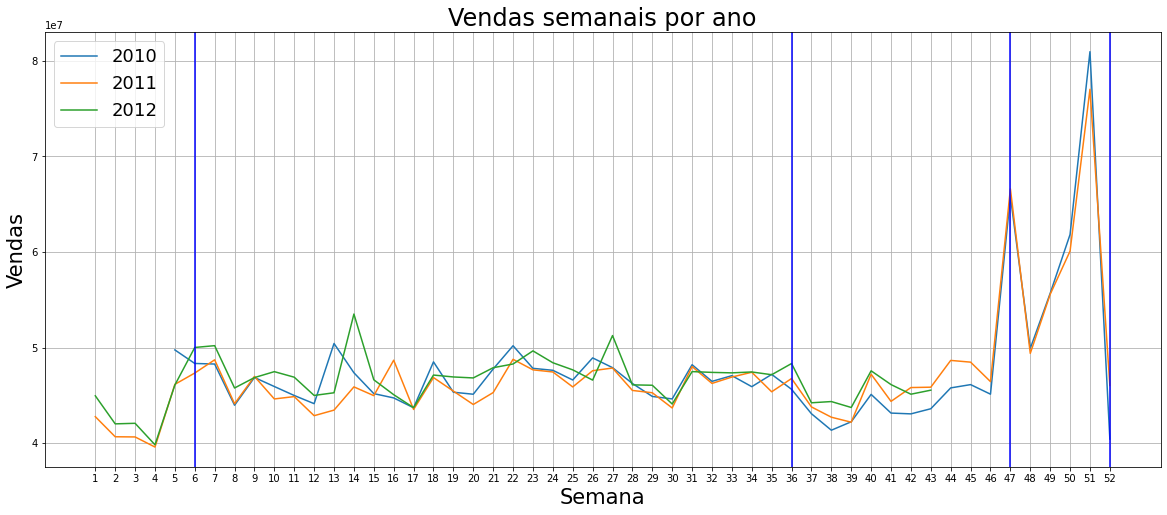

In [10]:
'''
Segundo passo:
- Plotar o volume de vendas semanais indicando a semana
que ocorre o feriado com uma linha azul
'''
plt.figure(figsize=(20,8))
for year in data.year.unique():
    var = data[data.year==year]['Weekly_Sales'].groupby(data['week']).sum()
    sns.lineplot(var.index, var.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(data.year.unique(), loc='best', fontsize=18)
plt.title('Vendas semanais por ano', fontsize=24)
plt.ylabel('Vendas', fontsize=21)
plt.xlabel('Semana', fontsize=21)
for value in data[data.IsHoliday].week.unique():
    plt.axvline(value, color='blue')
plt.show()

Com base no gráfico acima podemos fazer as seguintes observações:
* Super bowl: é um feriado com pouco impacto nas vendas. Se você observar os meses circunvizinhos, a semana que ocorre o Super Bowl pouco se destoa das demais semanas e talvez seja um feriado que ser melhor explorado pela gestão do varejo para expandir as vendas nesse feriado.
* Labor day: também é um feriado com pouco destaque. Ao longo dos três anos poucas vendas a mais são feitas nessa data. Provavelmente, esse feriado é usado para renovação de estoque e reabastecimento dos estoques dos novos produtos que serão vendidos no Natal.
* Thanksgiving: Primeiro feriado do ano com grande impacto nas vendas. Percebe-se um grande volume de vendas nessa semana, embora que, esse volume de vendas tenha pouco variado ao longo dos anos.
* Christmas: Poucas semanas após o dia de ação de graças ocorre o Natal. Ao observar as vendas realizadas no Natal, percebe-se um baixo volume nas vendas. Entretanto, a semana que antecede o Natal apresenta um pico de vendas que supera todas as demais semanas do ano, para todos os anos fornecidos. Assim, faz-se necessário que o varejo se prepare antecipadamente para uma semana de vendas aquecida do Natal.


Com base nessas análises, podemos perceber que os dois primeiros feriados (Super bowl e Labor day) tem um nível de vendas constante quando comparado as semanas de seu entorno. Por outro lado, os feriados de Thanksgiving e Christmas fazem as pessoas consumir muito mais que as demais semanas. Respondendo a questão: Os feriados realmente impactam as vendas? Depende. Sim, ao considerar os feriados de Thanksgiving e Christmas. Não, ao considerar os feriados de Super bowl e Labor day.

## Questão 2: As vendas semanais são consistentes ao longo dos anos?

É comum que grandes varejistas tenham semanas com números excepcionais de vendas. Por exemplo, a Alibaba informou que no 'Dia dos solteiros', a movimentação de vendas na China foi de R$ 300 milhões [(fonte)](https://g1.globo.com/economia/noticia/2020/11/11/dia-dos-solteiros-movimenta-cerca-de-r-300-bilhoes-em-vendas-na-china.ghtml). Em relação ao problema de negócio, a varejista precisa se preparar antecipadamente para semanas com pico de vendas, buscando evitar atrasos nas entregas, minimizar a falta de itens no estoque, expandir a disponibilidade dos servidores para evitar congestionamento no site, entre outras logísticas que permitam melhorar a experiência do cliente e maximizar o lucro da empresa. Diante desse cenário, surge um importante problema técnico, que seria prever as vendas semanais com base em dados de vendas de anos anteriores. Para responder essa pergunta, usei uma matriz de correlação que analisa as vendas semanais em todos os anos registrados.

In [11]:
'''
Primeiro passo:
Estruturando o dado ao formato necessário para visualização.
'''
corr = pd.DataFrame([])
for year in data.year.unique():
    corr = pd.concat([corr, data[data.year==year]['Weekly_Sales'].groupby(data['week']).sum()], axis=1)
columns_name = list()
for year in data.year.unique():
    columns_name += [f'data_{year}']
corr.columns = columns_name

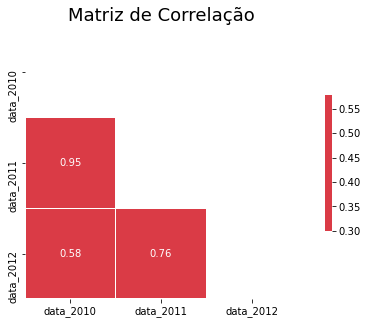

In [12]:
'''
Calculando o coeficiente de correlação das vendas semanais agrupando-as por ano.
'''
corr = corr.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(10, 5))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Matriz de Correlação', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Observando a matriz de correlação acima, percebemos que há uma forte correlação entre as vendas semanais para os três anos fornecidos.

O que isso quer dizer? Com base no volume de vendas realizados nos anos anteriores, existem fortes indícios que as oscilações no volume de vendas se mantenham. Isso quer dizer que o volume de vendas crescem (ou diminuem) de maneira consistente ao longo dos anos. E que essas oscilações podem variar pouco de um ano para outro e muito no longo prazo.

Observe a correlação de 0.95% entre 2010 e 2011, valor extretamente alto. Outra correlação muito forte de 0.76 entre os anos de 2011 e 2012. Entretanto, anos mais distantes como 2010 e 2012 apresentam um nível de correlação embora alto mas um pouco inferior que os outros dois casos (0.58), isso pode indicar que o nível de vendas semanais pode se parecer muito com o ano anterior, mas que essa sútil mudança ao longo dos anos pode fazer com que as vendas desse ano sejam muito diferentes das vendas de 5 anos atrás.

Assim, o cientista de dados que analisa os dados dessa empresa, deve ter cuidado ao modelar o problema usando modelos com algoritmos como LSTM que usam muitos dados históricos, pois os mesmos, podem usar como referência um volume de vendas que não reflete a realidade do ano atual.

## Questão 3: Existe relevância na correlação das variáveis?

Ao lapidar os dados em busca de extrair insights relevantes para a tomada de decisão, um aspecto importante a se observar é se existem aspectos ou fenômenos que expliquem a correlação das variáveis coletadas. Com isso, novas ideias podem ser implementadas ao modelo e aspectos não observados podem ser notados. Assim, busquei fazer uma matriz de correlação para todas as variáveis que julguei fazer sentido observar a correlação.

*Disclaimer*: Correlação é uma medida que indica relação entre duas variáveis, que não necessariamente indicam relação de causalidade entre elas. Por exemplo, suponhamos que existe uma alta correlação entre o número de banheiros de uma casa e a renda bruta da família que habita nessa casa. Isso quer dizer que pessoas que ganham mais, tendem a morar em casas com mais banheiros. Ou seja, há correlação positiva entre essas duas variáveis. No entanto, se você construir mais banheiros em sua casa, você não irá aumentar a sua renda bruta. Pois essa não há relação de causalidade entre essas duas variáveis.

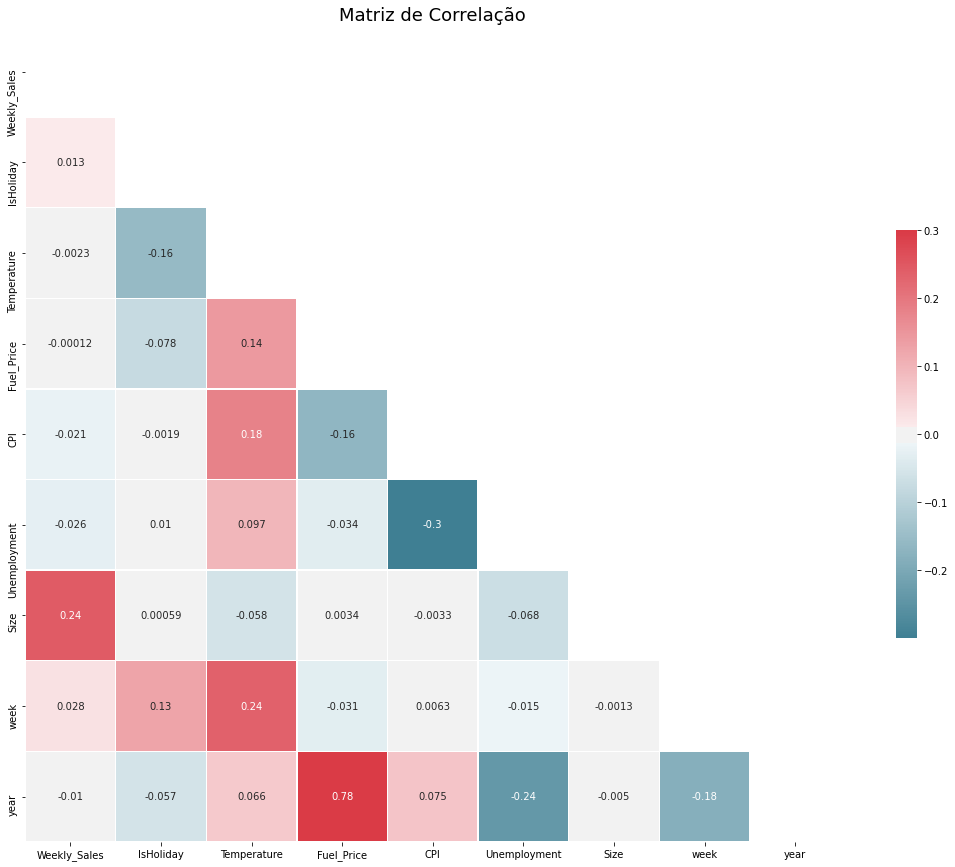

In [13]:
'''
Calculando o coeficiente de correlação entre as variáveis.

Para responder a questão acima, foi desconsiderado algumas variáveis:

- Store e Dept: o identificador da loja e do departamento são variáveis categóricas armazenadas como números,
e para analisar o coeficiente de correlação entre duas variáveis você precisa analisar variáveis númericas.
- MarkDown: Existem alguns aspectos que a análise dessa variável nesse quesito podem levar a conclusões imprecisas.
As minhas duas maiores preocupações são:
I) Os dados estão anonimizados e isso prejudica na interpretabilidade da análise. Como explicar a correlação
se você não entende porque ela acontece já que os dados são anônimos?
II) Os dados estão disponíveis para parte da base, ou seja, você pode tecer análises que só são válidas para
uma parte dos dados. Extender essas conclusões para o resto da base pode levar a conclusões erradas.

Por tal razão, resolvi desconsiderar essas variáveis na análise.
'''

corr = data.drop(['Store', 'Dept', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Matriz de Correlação', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Ao analisar uma matriz de correlação, procuramos entender quais aspectos podem explicar correlações fortes (sejam elas positivas ou negativas). Destaquei algumas correlações e busquei tecer a minha análise sobre elas. A variável mais importante a se observar são as vendas semanais. Entretanto, essa variável só possui correlação relevante com uma outra variável que é o tamanho da loja. Seria muito interessante ver outras variáveis correlacionadas ao volume de vendas semanal. Mas, busquei aprofundar em cada detalhe da análise.

**CORRELAÇÕES POSITIVAS**
* 0.78 Preço do combustível vs Ano: Esse alto índice de correlação pode ser explicado pelo aumento no preço dos combustíveis ao longo dos anos. Entretanto, observando o preço do combustível e as vendas semanais, percebemos que mesmo o preço do combustível tenha subido ao longo dos anos, as vendas semanais não foi impactada por esse aspecto (correlação muito próxima de zero).
* 0.24 Tamanho da loja vs Vendas Semanais: Um aspecto bastante relevante no volume de vendas semanais deveria ser o tamanho da loja. Quanto maior a loja, maior o volume de vendas. Entretanto, esse indicador nos mostra que essa regra não necessariamente é válido. Isto é, se quanto maior a loja, maior fosse o volume de vendas, e essa regra fosse sempre obedecida, nós observaríamos um coeficiente de correlação entre essas duas variáveis igual a 1.0. No entanto, esse valor (0.24) indica uma correlação moderada, e que maiores lojas tendem a vender mais em boa parte dos casos.
* 0.24 Temperatura vs Semana: Ao passar das semanas a temperatura também aumenta pois o verão americano acontece aproximadamente no meio do ano e temperatura volta a cair no segundo semestre. Sendo assim, essa correlação apresenta pouca relevância para a análise.
* 0.18 CPI e Temperatura + 0.14 Preço do Combustível e Temperatura: Considerando o aquecimento global um fenômeno verdadeiro, ou seja, que ao longo dos anos a temperatura irá sempre subir, e que, índices de preços como o CPI também tendem a ser sempre positivos pois a inflação tendem a aumentar esse valor, e consequentemente também elevar o preço do combustível. Vemos uma leve correlação entre esses aspectos. O índice de preços ao consumir sobe com uma correlação de 0.18 em relação a temperatura, como também, a temperatura sobe com uma correlação de 0.14 com o preço do combustível.

**CORRELAÇÕES NEGATIVAS**
* -0.3 CPI e desemprego: Essa medida indica que o índice de preços ao consumidor é menor quando o desemprego está mais alto. *Disclaimer*: Embora ambas as variáveis não apresentem correlação significativa entre si e o volume de vendas semanais, esse tipo de observação pode parecer fazer pouco sentido para nós, mas variáveis descorrelacionadas ajudam a máquina a fazer melhores predições. Imagine uma base de dados com redundância nas variáveis, por exemplo, a área de uma casa medida em centímetros quadrados e metros quadrados. A correlação entre essas duas variáveis seria de 100%, por outro lado, fornecer ambas as variáveis para o modelo traria pouco ganho na capacidade preditiva. Ou seja, por mais que essas correlações façam pouco sentido para nós, podem ser bastante interessantes para o modelo.
* -0.24 Desemprego e Ano: Essa correlação indica que o desemprego teve leve queda ao longo dos anos. Por outro lado, essa relação não impactou no volume de vendas. Entretanto, foi disponibilizado o histórico de apenas 3 anos. É possível que as pessoas que conseguiram emprego busquem quitar as suas dívidas e posteriormente fazer mais compras. Com um histórico maior, tendo acesso aos anos seguintes, eu buscaria observar se houve aumento no volume de vendas que pudesse estar associado a taxa de desemprego. É difícil de isolar apenas esse aspecto na análise, mas um modelo que usa dados históricos poderá se beneficiar com essa relação.
* -0.16 CPI e Preço de combustível: Percebe-se que o preço do combustível subiu ao longo dos anos (correlação de 0.78 entre o preço de combustível e o ano), e que o índice de preços ao consumidor "andou de lado" ao longo do período (correlação de 0.075 do CPI e ano). No entanto, o preço do combustível têm correlação ligeiramente negativa em relação ao CPI. Ou seja, o índice de preços ao consumidor deve estar associado a outras variáveis que andam em sentidos levemente opostos ao preço do combustível.



## Questão 4: A categoria do estabelecimento influência nas vendas?

Nos dados observamos três categorias de estabelecimentos (A, B e C). Essas categorias de estabelecimentos podem identificar diferentes aspectos, por exemplo, o público-alvo do estabelecimento, ou a qualidade da estrutura física da loja, ou a lucratividade do empreedimento. De toda maneira, o uso apropriado dessas informações podem trazer ganhos, tanto para o negócio quanto para o cientista de dados. Por exemplo, ao abrir uma nova loja, a empresa financia diversos planos de negócios que buscam maximizar os ganhos da companhia, entre elas, essa métrica pode ajudar a definir esse melhor local. Por outro lado, o cientista de dados ao prever o nível de vendas, poderia usar essa informação ao seu favor. Será que a categoria do estabelecimento tem alguma relação com as vendas?

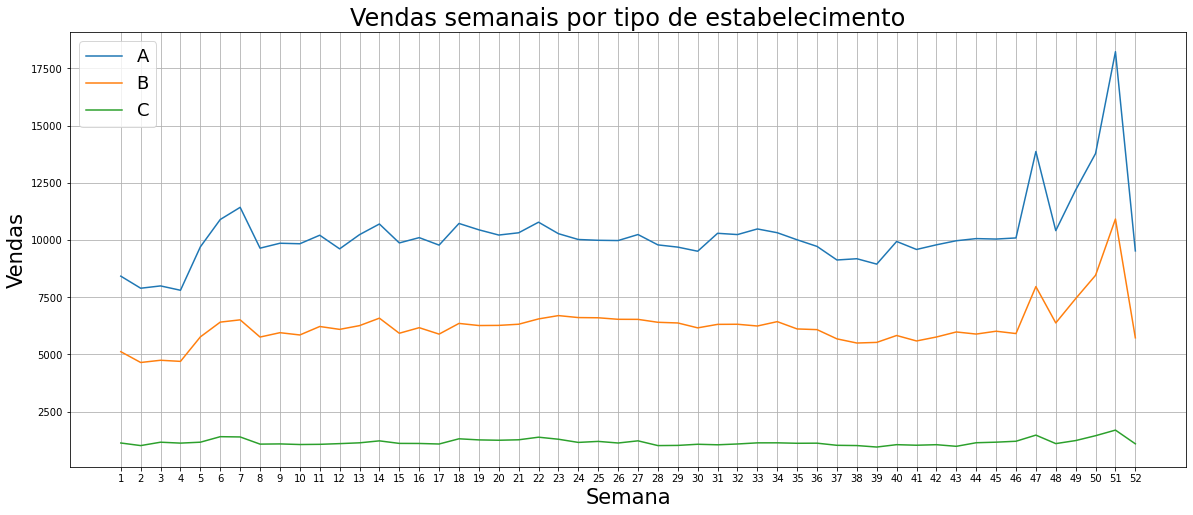

In [14]:
plt.figure(figsize=(20,8))
for type_ in data.Type.unique():
    var = data[data.Type==type_]['Weekly_Sales'].groupby(data['week']).median()
    sns.lineplot(var.index, var.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(data.Type.unique(), loc='best', fontsize=18)
plt.title('Vendas semanais por tipo de estabelecimento', fontsize=24)
plt.ylabel('Vendas', fontsize=21)
plt.xlabel('Semana', fontsize=21)
plt.show()

Observando o gráfico acima, vemos claramente que o volume de vendas (usando a mediana) por estabelecimento de cada categoria têm sim grande impacto nas vendas. E respondendo as questões levantadas no primeiro trecho desse tópico, essas categorias podem estar associadas ao volume de vendas de cada estabelecimento. Sendo os estabelecimentos mais lucrativos aqueles que pertecem a categoria A, e os menos lucrativos aqueles que pertecem a categoria C.

# Listar 1 limpeza que precisa ser feita nos dados e a executar

Uma boa limpeza de dados pode começar a ser feita tratando os dados faltantes. Diversas abordagens diferentes podem ser aplicadas, como por exemplo, imputar novos dados usando a média, ou a predição de algum modelo como uma regressão linear ou logística. No entando, precisamos usar alguma ferramenta adequada para essa análise. Vou começar o processo usando uma biblioteca chamada `missingno` [link](https://github.com/ResidentMario/missingno) que pode ser bastante útil nesses casos.

     |████████████████████████████████| 110 kB 427 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


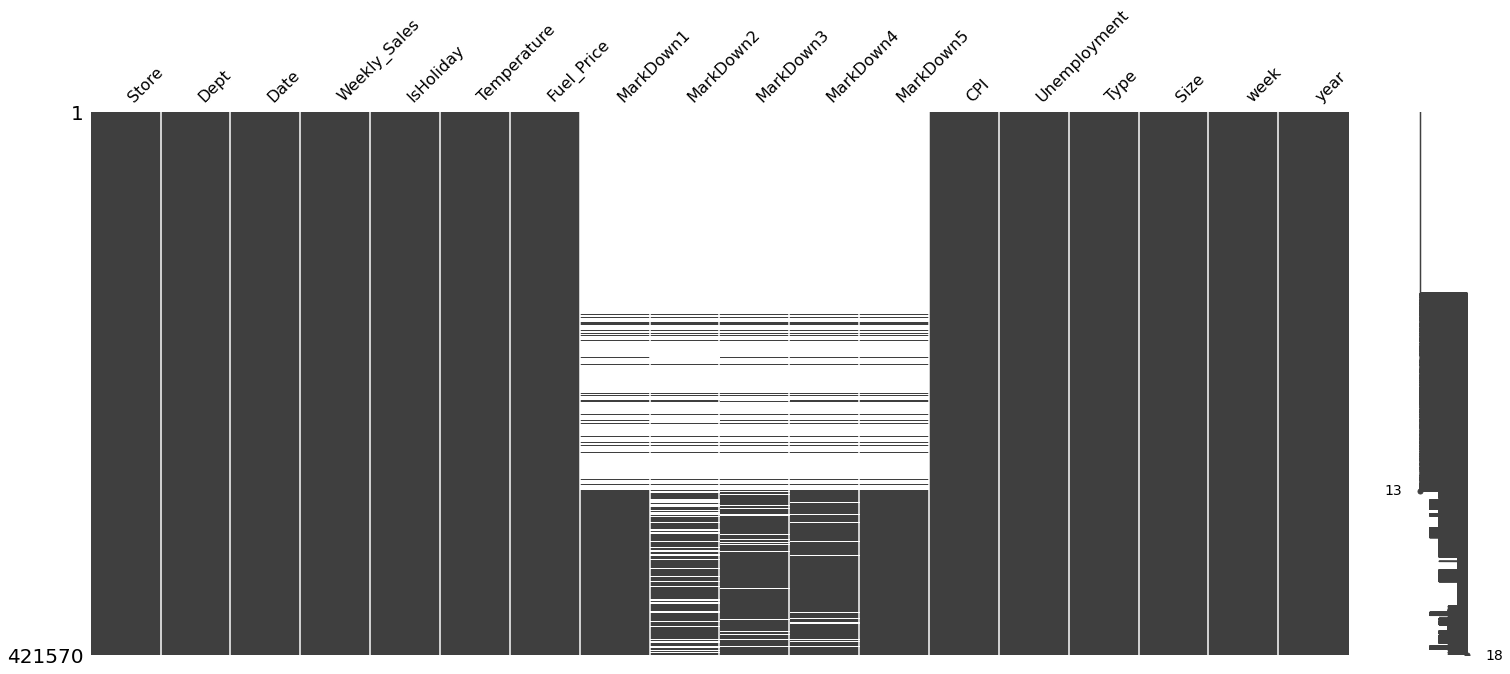

In [15]:
!pip install quilt
import missingno as msno
msno.matrix(data.sort_values(by='year'))

Com o auxílio dessa ferramenta, podemos visualizar os dados faltantes por células brancas nas respectivas colunas de cada variável. Com isso, percebemos que as variávels `MarkDown` começaram a ser registradas em 2011 ainda foi de maneira muito pequena (perceba o excesso de células em branco indicando a esparsidade dos dados). Mesmo após isso, em meados de 2012, ainda existe muitas células em branco para as variáveis `MarkDown2`, `MarkDown3` e `MarkDown4`. Nesse caso, pode-se usar algum modelo de predição para preencher os dados faltantes, como por exemplo, a fatoração de matrizes para os dados faltantes. No entanto, não há representantes para 2010 e poucos casos para 2011, assim, o preenchimento automático desses valores poderá enviesar o modelo que treinará com esses dados para fazer predições erradas. Sendo assim, a minha recomendação seria descartar esses atributos.


![](https://www.kaggle.com/static/images/host-home/host-home-research.png)

# Planejamento de aplicação de Machine Learning para resolver o problema
#### Escolher um algoritmo de Machine Learning 
#### Comentar sobre a escolha do algoritmo 


Esse problema se caracteriza pela predição no volume de vendas considerando uma linha temporal.
Sendo assim, pensamos que usar Redes Neurais Recorrentes (RNN/LSTM) possa ser o mais indicado. 
Entretanto convido para uma análise/reflexão mais profunda sobre essa abordagem.

A solução proposta pode envolver duas maneiras de modelar os dados: 
    I) Considerar o volume de vendas realizadas nas últimas semanas, ou
    II) Considerar o volume de vendas semanais realizadas nas mesmas semanas que a predita nos últimos anos.
Detalhando um pouco mais:

A solução (I) indica que o volume de vendas nas últimas `n` semanas pode não ser útil para a modelo pois as semanas de picos são antecedidas por semanas de vendas comuns, e maior parte das semanas tem um volume de vendas praticamente constante. Nesse caso, o modelo poderia ter dificuldade em prever o volume de vendas nas semanas finais do ano pois poderiam ser consideradas *outliers*. Um problema clássico entre especialização ou generalização de modelos, um *trade-off* onde você melhora a acurácia ao custo de diminuir a capacidade de generalização e vice-versa. 

A solução (II) pode parecer mais promissora por alguns aspectos, isto é, olhando o volume de vendas realizada em uma mesma semana nos diferentes anos, você percebe que esse volume praticamente não muda. Ou seja, caso você queira prever o volume de vendas na semana 23, em vez de você olhar para as `n` semanas anteriores a semana 23. Você deveria observar o volume de vendas da semana 23 nos anos anteriores. No entanto, ao usar essa abordagem você esbarra com um problema, pois os dados são limitados e você não terá muitos exemplos para treinar o modelo, consequentemente, ele poderá não apresentar um bom desempenho.

Nesse sentido, penso que tratar problemas envolvendo séries temporais, o uso de redes neurais recorrentes (do inglês, RNN) pode fazer sentido. No entanto, o pequeno volume de dados me faz pensar que alguns problemas poderão acontecer. Por exemplo, o modelo ter dificuldades para convergir, e isso impactar em seu desempenho. Nesse caso, eu acredito que diante o cenário encontrado, a solução mais promissora possa ser usando árvores de decisão. Diante a minha experiência, usaria alguma implementação como [XGBoost](https://xgboost.readthedocs.io/en/latest/) ou o [CatBoost](https://catboost.ai/) para solucionar esse problema. Sendo este último algoritmo, bastante promissor por apresentar uma funcionalidade específica para interpretação de modelos que é o uso do [SHAP](https://github.com/slundberg/shap), o que permite identificar quais variáveis estão constribuindo para a previsão do modelo. Esse tipo de técnica (SHAP) permite trazer interpretabilidade para qualquer tipo de modelo *machine-learning*, até mesmo os que são considerados *black-box*. E o CatBoost é um modelo que traz isso implementado nativamente. 




![](https://www.kaggle.com/static/images/about/inclass/howitworks@2x.png)

# Autocrítica e próximos passos 
#### Enumerar eventuais problemas e limitações da estratégia 
#### Comentar sobre o que você teria feito se tivesse mais tempo para tratar o problema 

Eu acredito que algumas soluções mais criativas e rebuscadas podem apresentar desempenho superior ao que eu propus.

Entretanto, acredito no princípio de Pareto, em que você realiza 80% de uma tarefa em 20% do tempo.

Sendo assim, eu testaria a abordagem proposta e veria o resultado do modelo, após isso, estudaria o custo-benefício em aplicar mais esforços na abordagem proposta para melhorar o desempenho, por exemplo, usando alguma técnica como *oversampling* (aumento no volume de dados de maneira sintética), *feature generation* (geração de novas variáveis) ou *fine-tunning* (modificação nos hiper-parâmetros do modelo para aumentar o desempenho do modelo). Certamente, se eu tivesse mais tempo, buscaria investir esforços nas técnicas citadas aqui, pois não consigo pensar em algoritmos de machine-learning que pudessem apresentar soluções melhores. 






![](https://www.vogue.pt/media/content/balanco-me-too-times-up-assedio-sexual.jpg)